<a href="https://colab.research.google.com/github/victorhss21/previsao_serie_temporal/blob/main/Projecao_ST_2030_vfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import das libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## Carregamento dos dados

In [2]:
df_x = pd.DataFrame({
    'ANO': [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
    'PIP': [3.98, 3.99, 3.86, 0.50, -0.50, -1.30, 1.80, 1.20, 0.20, -3.90, 4.00, 3.00, 3.24, 3.55, 2.16, 1.57, 2.07, 1.74, 2.00, 2.00],
    'IPCA': [5.80, 5.84, 5.91, 6.41, 10.67, 6.29, 2.95, 3.75, 4.31, 4.52, 10.06, 5.79, 4.62, 4.03, 4.86, 4.47, 4.00, 3.58, 3.50, 3.50],
    'SELIC': [11.69, 8.36, 8.22, 10.93, 13.53, 14.06, 9.74, 6.43, 5.78, 2.56, 5.03, 12.84, 13.03, 10.87, 15.00, 14.20, 14.72, 11.07, 9.58, 9.00]
})

df_y = pd.DataFrame({
    'ANO': range(2011, 2031),
    'VOLUME_ANUAL': [
        2660091089807, 3181099498508.7, 37223960173240.7, 3782462549508.3,
        3856101894913.6, 44409762752522.3, 44474913926598.6, 47646353108643.9,
        5430403824974.0, 5961515278883.3, 7354750691086.1, 93219164337434.4,
        101151647985604.0, 11018532814768.4, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    ]
})

# Combinação dos datasets
df = pd.merge(df_x, df_y, on='ANO')
df['ANO'] = pd.to_datetime(df['ANO'], format='%Y')
df.set_index('ANO', inplace=True)

## Engenharia de variáveis

In [3]:
import numpy as np
import pandas as pd
from itertools import combinations

# Parte 0: df já está pronto como no enunciado (index datetime por ANO)

# Parte 1: criar lags (1 janela) para as variáveis explicativas
exog_cols = ['PIP', 'IPCA', 'SELIC']  # manter 'PIP' conforme seus dados (se for PIB, renomeie antes)
for col in exog_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

# Parte 2: criar versão log do target (tratando zeros como ausentes)
# Se fizer sentido econômico, pode usar log1p; aqui preferimos NaN para zeros (dados ausentes no fim)
df['log_VOLUME_ANUAL'] = np.where(df['VOLUME_ANUAL'] > 0,
                                  np.log(df['VOLUME_ANUAL']),
                                  np.nan)

# Parte 3: criar termos de interação entre variáveis explicativas (atuais)
for a, b in combinations(exog_cols, 2):
    df[f'{a}x{b}'] = df[a] * df[b]

# Parte 4 (opcional, recomendado): interações entre o nível atual e seu lag (efeitos de persistência)
for col in exog_cols:
    df[f'{col}x{col}_lag1'] = df[col] * df[f'{col}_lag1']

# Parte 5 (opcional): termos quadráticos para não linearidades suaves
for col in exog_cols:
    df[f'{col}_sq'] = df[col] ** 2

# Parte 6: alinhar amostra para modelagem
# - Remover primeira linha que terá NaN por causa do shift;
# - Se o objetivo é treinar com log do target, remover linhas com log_VOLUME_ANUAL NaN (zeros)
feature_cols = (
    exog_cols +
    [f'{c}_lag1' for c in exog_cols] +
    [f'{a}x{b}' for a, b in combinations(exog_cols, 2)] +
    [f'{c}x{c}_lag1' for c in exog_cols] +
    [f'{c}_sq' for c in exog_cols]
)

# Data frame de treino para modelos supervisionados (ex.: ML com X(t) e y(t))
df_train = df.loc[:, feature_cols + ['VOLUME_ANUAL', 'log_VOLUME_ANUAL']].copy()
df_train = df_train.dropna(subset=[f'{c}_lag1' for c in exog_cols])  # remove a primeira linha

# Se o target em log for o alvo do modelo, também remova NaN de log (linhas com VOLUME=0)
df_train_log = df_train.dropna(subset=['log_VOLUME_ANUAL']).copy()

Agore temos 3 dataframes:
- `df`: Datafrme completo após transformações
- `df_train`: Dataframe de treino para modelos supervisionados (ex.: ML com X(t) e y(t))
- `df_train_log`: Dataframe de treino se o target em log for o alvo do modelo, também remova NaN de log (linhas com VOLUME=0)

In [4]:
display(df)

,PIP,IPCA,SELIC,VOLUME_ANUAL,PIP_lag1,IPCA_lag1,SELIC_lag1,log_VOLUME_ANUAL,PIPxIPCA,PIPxSELIC,IPCAxSELIC,PIPxPIP_lag1,IPCAxIPCA_lag1,SELICxSELIC_lag1,PIP_sq,IPCA_sq,SELIC_sq
ANO,,,,,,,,,,,,,,,,,
2011-01-01,3.98,5.80,11.69,2.660091e+12,NaN,NaN,NaN,28.609381,23.0840,46.5262,67.8020,NaN,NaN,NaN,15.8404,33.6400,136.6561
2012-01-01,3.99,5.84,8.36,3.181099e+12,3.98,5.80,11.69,28.788248,23.3016,33.3564,48.8224,15.8802,33.8720,97.7284,15.9201,34.1056,69.8896
2013-01-01,3.86,5.91,8.22,3.722396e+13,3.99,5.84,8.36,31.247974,22.8126,31.7292,48.5802,15.4014,34.5144,68.7192,14.8996,34.9281,67.5684
2014-01-01,0.50,6.41,10.93,3.782463e+12,3.86,5.91,8.22,28.961396,3.2050,5.4650,70.0613,1.9300,37.8831,89.8446,0.2500,41.0881,119.4649
2015-01-01,-0.50,10.67,13.53,3.856102e+12,0.50,6.41,10.93,28.980678,-5.3350,-6.7650,144.3651,-0.2500,68.3947,147.8829,0.2500,113.8489,183.0609
2016-01-01,-1.30,6.29,14.06,4.440976e+13,-0.50,10.67,13.53,31.424480,-8.1770,-18.2780,88.4374,0.6500,67.1143,190.2318,1.6900,39.5641,197.6836
2017-01-01,1.80,2.95,9.74,4.447491e+13,-1.30,6.29,14.06,31.425946,5.3100,17.5320,28.7330,-2.3400,18.5555,136.9444,3.2400,8.7025,94.8676
2018-01-01,1.20,3.75,6.43,4.764635e+13,1.80,2.95,9.74,31.494827,4.5000,7.7160,24.1125,2.1600,11.0625,62.6282,1.4400,14.0625,41.3449
2019-01-01,0.20,4.31,5.78,5.430404e+12,1.20,3.75,6.43,29.323035,0.8620,1.1560,24.9118,0.2400,16.1625,37.1654,0.0400,18.5761,33.4084


## Avaliando correlações

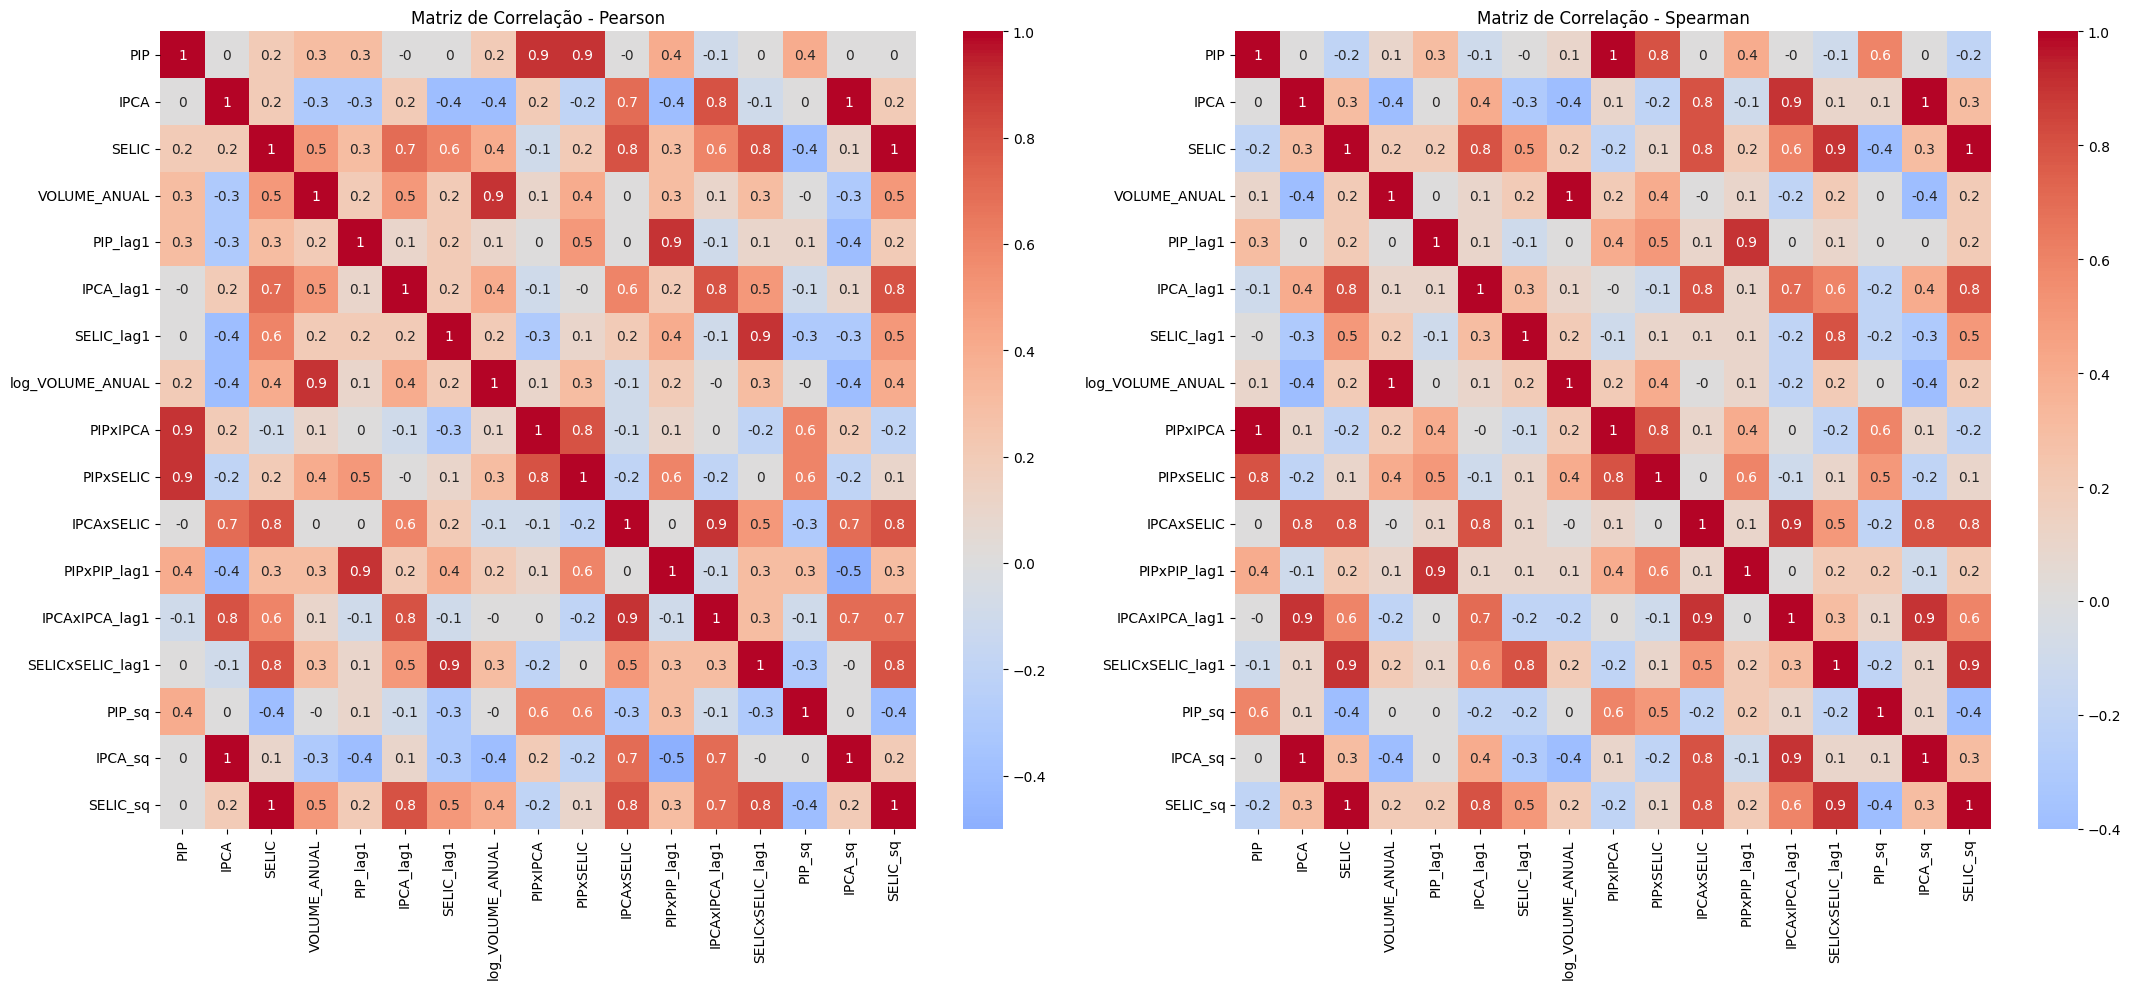

In [5]:
# Matriz de correlação
correlation_matrix_pearson = round(df[df.index.year <= 2025].dropna().corr(method='pearson'),1)
correlation_matrix_spearman = round(df[df.index.year <= 2025].dropna().corr(method='spearman'),1)

fig, axes = plt.subplots(1, 2, figsize=(22, 10))

sns.heatmap(correlation_matrix_pearson, annot=True, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Matriz de Correlação - Pearson')

sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Matriz de Correlação - Spearman')

plt.tight_layout()
plt.show()

## Definindo função de Walk Forward

In [6]:
#######################################################
# DEFINIINDO FUNÇÃO PARA WALK FORWARD VALIDATION
#######################################################
import numpy as np
import pandas as pd
from typing import Dict, Any
from math import sqrt

def _mae(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.mean(np.abs(y_true - y_pred)))

def _mse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.mean((y_true - y_pred)**2))

def _rmse(y_true, y_pred):
    return float(sqrt(_mse(y_true, y_pred)))

def _mape(y_true, y_pred, eps: float = 1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def walk_forward_simple_v3(
    model,
    X,
    y,
    train_window: int = 10,
    horizon: int = 2,
    n_folds: int = 3,
    gap: int = 0,
    clone_each_fold: bool = True,
    build_from: str = 'start',  # 'start' ou 'end'
    step: int = 1,              # novo: avanço entre folds (1 para usar todos os pontos)
    verbose: bool = False
) -> Dict[str, Any]:

    # 1) Garantir pandas
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X).copy()
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("y como DataFrame deve ter apenas 1 coluna.")
        y = y.iloc[:, 0]
    elif not isinstance(y, pd.Series):
        y = pd.Series(y).copy()

    # 2) Alinhamento por índice
    common_idx = X.index.intersection(y.index)
    X = X.loc[common_idx].copy()
    y = y.loc[common_idx].copy()

    n = len(X)
    if n < (train_window + gap + horizon):
        raise ValueError("Dados insuficientes para ao menos 1 fold com os parâmetros atuais.")
    if step <= 0:
        raise ValueError("step deve ser >= 1.")

    # 3) Construção dos folds
    folds_pos = []
    if build_from == 'start':
        k = 0
        while len(folds_pos) < n_folds:
            train_start = k * step
            train_end   = train_start + train_window
            test_start  = train_end + gap
            test_end    = test_start + horizon
            if test_end > n:
                break
            folds_pos.append((train_start, train_end, test_start, test_end))
            k += 1
    elif build_from == 'end':
        last_test_start = n - horizon
        k = 0
        while len(folds_pos) < n_folds:
            test_start = last_test_start - k * step
            test_end   = test_start + horizon
            train_end  = test_start - gap
            train_start= train_end - train_window
            if train_start < 0 or test_end > n:
                break
            folds_pos.append((train_start, train_end, test_start, test_end))
            k += 1
        folds_pos = folds_pos[::-1]
    else:
        raise ValueError("build_from deve ser 'start' ou 'end'.")

    if len(folds_pos) == 0:
        raise ValueError("Não foi possível construir folds com os parâmetros fornecidos.")

    # 4) Clonagem do estimador (opcional)
    est_clone_fn = None
    if clone_each_fold:
        try:
            from sklearn.base import clone as sk_clone
            est_clone_fn = sk_clone
        except Exception:
            est_clone_fn = None

    folds_out = []
    for i, (tr_s, tr_e, te_s, te_e) in enumerate(folds_pos, start=1):
        X_tr = X.iloc[tr_s:tr_e]; y_tr = y.iloc[tr_s:tr_e]
        X_te = X.iloc[te_s:te_e]; y_te = y.iloc[te_s:te_e]

        # Limpeza de NaNs por fold (lags, etc.)
        tr_mask = (~X_tr.isna().any(axis=1)) & (~y_tr.isna())
        te_mask = (~X_te.isna().any(axis=1)) & (~y_te.isna())
        X_tr_c = X_tr.loc[tr_mask]; y_tr_c = y_tr.loc[tr_mask]
        X_te_c = X_te.loc[te_mask]; y_te_c = y_te.loc[te_mask]

        if len(X_tr_c) == 0 or len(X_te_c) == 0:
            if verbose:
                print(f"[Fold {i}] Janela vazia após limpeza. Pulando.")
            continue

        if est_clone_fn is not None:
            est = est_clone_fn(model)
        else:
            try:
                est = model.__class__(**getattr(model, "get_params", lambda: {})())
            except Exception:
                est = model

        est.fit(X_tr_c, y_tr_c)
        y_pred = est.predict(X_te_c)

        metrics = {
            "MAE":  _mae(y_te_c.values, y_pred),
            "MAPE": _mape(y_te_c.values, y_pred),
            "MSE":  _mse(y_te_c.values, y_pred),
            "RMSE": _rmse(y_te_c.values, y_pred),
        }

        if verbose:
            print(f"[Fold {i}] train=({tr_s}:{tr_e}) test=({te_s}:{te_e}) "
                  f"n_tr={len(X_tr_c)} n_te={len(X_te_c)} | {metrics}")

        folds_out.append({
            "fold": i,
            "train_size": int(len(X_tr_c)),
            "train_index": X_tr_c.index,
            "test_index": X_te_c.index,
            "y_true": y_te_c.values,
            "y_pred": np.asarray(y_pred),
            "metrics": metrics
        })

    if len(folds_out) == 0:
        raise RuntimeError("Todos os folds foram descartados por falta de dados após limpeza.")

    metrics_mean = {}
    for k in ["MAE", "MAPE", "MSE", "RMSE"]:
        vals = [f["metrics"][k] for f in folds_out if k in f["metrics"]]
        if len(vals) > 0:
            metrics_mean[k] = float(np.mean(vals))

    return {
        "folds": folds_out,
        "metrics_mean": metrics_mean,
        "params": {
            "train_window": train_window,
            "horizon": horizon,
            "n_folds": len(folds_out),
            "gap": gap,
            "build_from": build_from,
            "step": step
        }
    }

### Exemplo de uso:

In [7]:
from sklearn.linear_model import Ridge

df_filtered = df.dropna().copy()
X = df_filtered.drop(['VOLUME_ANUAL','log_VOLUME_ANUAL'], axis=1)
y = df_filtered['VOLUME_ANUAL']

modelo = Ridge(alpha=1.0, random_state=42)

res = walk_forward_simple_v3(
    model=modelo,
    X=X,
    y=y,
    train_window=10,
    horizon=2,
    n_folds=2,
    gap=0,
    clone_each_fold=True,
    build_from='start',
    step=1,               # avanço de 1 período para habilitar o 2º fold
    verbose=True
)

[Fold 1] train=(0:10) test=(10:12) n_tr=10 n_te=2 | {'MAE': 71251444831319.0, 'MAPE': 73.52396427597296, 'MSE': 5.081015714393933e+27, 'RMSE': 71281243776984.8}
[Fold 2] train=(1:11) test=(11:13) n_tr=10 n_te=2 | {'MAE': 59799216127755.22, 'MAPE': 426.81628628764975, 'MSE': 4.5454149938424956e+27, 'RMSE': 67419692923080.69}


In [8]:
# Verificando as métricas por fold
print("Métricas médias:", res["metrics_mean"],'\n')
for f in res["folds"]:
    print(f"Fold {f['fold']}")
    print("  Tamanho treino:", f["train_size"])
    print("  Treino:", f["train_index"].tolist())
    print("  Teste :", f["test_index"].tolist())
    print("  y_true:", f["y_true"])
    print("  y_pred:", f["y_pred"])
    print("  Métricas:", f["metrics"])
    print('\n')

Métricas médias: {'MAE': 65525330479537.11, 'MAPE': 250.17012528181135, 'MSE': 4.8132153541182143e+27, 'RMSE': 69350468350032.74} 

Fold 1
  Tamanho treino: 10
  Treino: [Timestamp('2012-01-01 00:00:00'), Timestamp('2013-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2016-01-01 00:00:00'), Timestamp('2017-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'), Timestamp('2019-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')]
  Teste : [Timestamp('2022-01-01 00:00:00'), Timestamp('2023-01-01 00:00:00')]
  y_true: [9.32191643e+13 1.01151648e+14]
  y_pred: [1.99068159e+13 1.70342189e+14]
  Métricas: {'MAE': 71251444831319.0, 'MAPE': 73.52396427597296, 'MSE': 5.081015714393933e+27, 'RMSE': 71281243776984.8}


Fold 2
  Tamanho treino: 10
  Treino: [Timestamp('2013-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2016-01-01 00:00:00'), Timestamp('2017-01-01 00:00:

## Treinando & Avaliando modelos

### Preparando dados:

In [9]:
# Separando dados para treino
df_filtered = df.dropna().copy()
X = df_filtered.drop(['VOLUME_ANUAL','log_VOLUME_ANUAL'], axis=1)
y = df_filtered['VOLUME_ANUAL']

In [10]:
# X e y para ARIMAX/Prophet: explicativas contemporâneas
X_exog = X[['PIP', 'IPCA', 'SELIC']].copy()
y_lvl  = y.copy()

# # Garante lags para modelos 3 e 4 (se ainda não existirem)
X_lag = X[['PIP_lag1','IPCA_lag1','SELIC_lag1']].copy()
y_lag = y.copy()

### Instanciando modelos:

#### SARIMX (1,1,1)

In [108]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_sarimax_fixed(
    X_tr, y_tr,
    order=(1,1,1),                    # parâmetros fixos: AR=1, diferença=1, MA=1
    seasonal_order=(0,0,0,0),         # sem sazonalidade
    enforce_stationarity=False,       # flexibiliza restrições para amostras pequenas
    enforce_invertibility=False,      # idem
    max_iter=500                      # limite de iterações do otimizador
):
    """
    Treina SARIMAX com ordem fixa (1,1,1) - sem busca automática de parâmetros

    Parâmetros:
    - order: (p,d,q) fixo - AR(1), diferença(1), MA(1)
    - seasonal_order: componentes sazonais (desativados)
    - enforce_stationarity/enforce_invertibility: False para mais flexibilidade
    """
    # Limpa possíveis NaNs
    idx = X_tr.index.intersection(y_tr.index)
    X_tr = X_tr.loc[idx]
    y_tr = y_tr.loc[idx]
    mask = (~X_tr.isna().any(axis=1)) & (~y_tr.isna())
    Xc = X_tr.loc[mask]
    yc = y_tr.loc[mask]

    model = SARIMAX(
        endog=yc,
        exog=Xc,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=enforce_stationarity,
        enforce_invertibility=enforce_invertibility,
        trend="n"
    )
    res = model.fit(disp=False, maxiter=max_iter)

    return {"res": res}

def predict_sarimax_fixed(state, X_te):
    """Faz previsão com modelo SARIMAX já treinado"""
    res = state["res"]
    fc = res.get_forecast(steps=len(X_te), exog=X_te)
    return fc.predicted_mean.values

#### AutoARIMA

##### Conceito:

**Treinando um Modelo AutoARIMA com `pmdarima`: Guia Completo e Principais Parâmetros**

Treinar um modelo de séries temporais pode ser um processo complexo, especialmente na escolha dos parâmetros ótimos. A biblioteca `pmdarima` para Python simplifica enormemente essa tarefa com a função `auto_arima`, que automatiza a busca pelos melhores parâmetros para um modelo ARIMA ou SARIMA (ARIMA Sazonal).

Este guia completo irá detalhar como treinar um modelo `auto_arima` e destacar seus principais parâmetros para que você possa utilizá-lo de forma eficaz em suas previsões.

**O que é o `auto_arima`?**

O `auto_arima` é uma função que implementa o processo de busca automatizada dos parâmetros de um modelo ARIMA. Em vez de o analista ter que testar manualmente diversas combinações dos parâmetros `(p, d, q)` e dos sazonais `(P, D, Q, m)`, o `auto_arima` realiza uma busca em um espaço de possíveis modelos e seleciona aquele que minimiza um critério de informação, geralmente o AIC (Akaike Information Criterion). Isso economiza tempo e reduz a subjetividade na escolha do modelo.

**Como Treinar o Modelo: Um Passo a Passo**

O treinamento de um modelo `auto_arima` geralmente segue os seguintes passos:

1.  **Importação das Bibliotecas:** Comece importando a função `auto_arima` e a biblioteca `pandas` para manipulação dos dados.

    ```python
    import pmdarima as pm
    import pandas as pd
    ```

2.  **Preparação dos Dados:** Seus dados de série temporal devem estar em um formato adequado, como uma série do `pandas` ou um array do `numpy`. O índice da série temporal deve, idealmente, ser do tipo data/hora.

3.  **Instanciação e Treinamento:** A forma mais simples de treinar o modelo é passar a sua série temporal para a função `auto_arima`.

    ```python
    # Supondo que 'sua_serie_temporal' é uma série do pandas
    modelo = pm.auto_arima(sua_serie_temporal, seasonal=True, m=12)

    # Para visualizar os resultados do melhor modelo encontrado
    print(modelo.summary())
    ```

    Neste exemplo, `seasonal=True` indica que o `auto_arima` deve procurar por um modelo sazonal, e `m=12` especifica que a frequência sazonal é de 12 períodos (mensal).

4.  **Realização de Previsões:** Uma vez treinado, o modelo pode ser usado para fazer previsões.

    ```python
    # Prever os próximos 10 passos no tempo
    previsoes = modelo.predict(n_periods=10)
    ```

**Principais Parâmetros do `auto_arima`**

A flexibilidade e o poder do `auto_arima` vêm da sua capacidade de personalizar a busca do modelo através de diversos parâmetros. Os mais importantes são:

**Parâmetros Não Sazonais: `(p, d, q)`**

  * **`p` (Ordem Autoregressiva):** Refere-se ao número de observações passadas a serem incluídas no modelo. O `auto_arima` testa diferentes valores para `p`. Você pode limitar a busca com `start_p` e `max_p`.
  * **`d` (Ordem de Diferenciação):** É o número de vezes que os dados brutos são diferenciados para torná-los estacionários. O `auto_arima` utiliza testes de estacionariedade (como o teste ADF) para determinar o valor de `d`. Você pode forçar um valor específico se já souber a ordem de diferenciação necessária.
  * **`q` (Ordem da Média Móvel):** É o número de erros de previsão passados a serem incluídos no modelo. Similar ao `p`, a busca por `q` pode ser controlada com `start_q` e `max_q`.

**Parâmetros Sazonais: `(P, D, Q, m)`**

  * **`seasonal` (Booleano):** O parâmetro mais importante para modelos com sazonalidade. Defina como `True` para que o `auto_arima` procure por um modelo SARIMA. O padrão é `False`.
  * **`m` (Período Sazonal):** Representa o número de períodos em cada ciclo sazonal. Por exemplo, `m=12` para dados mensais, `m=4` para dados trimestrais e `m=7` para dados diários com padrão semanal. **Este é um parâmetro que geralmente precisa ser definido pelo usuário.**
  * **`P`, `D`, `Q` (Ordens Sazonais):** Análogos aos `p`, `d` e `q`, mas para a parte sazonal do modelo. `P` é a ordem autoregressiva sazonal, `D` é a ordem de diferenciação sazonal e `Q` é a ordem da média móvel sazonal. A busca por esses parâmetros pode ser controlada por `start_P`, `max_P`, `start_Q` e `max_Q`.

**Parâmetros de Controle da Busca**

  * **`stepwise` (Booleano):** Por padrão, é `True`, o que faz com que o `auto_arima` utilize um algoritmo de busca "passo a passo" (stepwise) que é mais rápido, mas pode não encontrar o melhor modelo absoluto. Definir como `False` fará uma busca exaustiva por todas as combinações de parâmetros dentro dos limites definidos, o que pode ser computacionalmente caro.
  * **`trace` (Booleano):** Se definido como `True`, a função imprimirá o status da busca, mostrando os modelos que estão sendo testados e seus respectivos valores de AIC. Isso é muito útil para acompanhar o processo de seleção.
  * **`information_criterion` (String):** Permite escolher o critério de informação a ser minimizado. As opções mais comuns são `'aic'` (padrão), `'bic'`, `'hqic'` e `'oob'`.
  * **`suppress_warnings` (Booleano):** Se `True`, suprime avisos que podem surgir durante o ajuste de alguns modelos.
  * **`error_action` (String):** Define o que fazer quando um erro ocorre ao ajustar um modelo. O padrão é `'warn'`, mas pode ser alterado para `'ignore'` ou `'raise'`.

**Exemplo Prático com Mais Parâmetros**

```python
import pmdarima as pm
from pmdarima import model_selection
import numpy as np

# Exemplo com dados sintéticos
y = pm.datasets.load_wineind(True)

# Dividindo os dados em treino e teste
train, test = model_selection.train_test_split(y, train_size=150)

# Treinando o modelo auto_arima com parâmetros mais específicos
modelo_ajustado = pm.auto_arima(train,
                             start_p=1, start_q=1,
                             max_p=3, max_q=3,
                             m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(modelo_ajustado.summary())

# Fazendo previsões no conjunto de teste
previsoes_teste = modelo_ajustado.predict(n_periods=test.shape[0])
```

Neste exemplo, a busca pelos parâmetros `p` e `q` é limitada entre 1 e 3. A sazonalidade é ativada com `m=12`, e a diferenciação não sazonal (`d`) e sazonal (`D`) são fixadas em 1. O `trace=True` nos permitirá ver o processo de busca do `auto_arima`.

Ao compreender e ajustar esses parâmetros, você pode guiar a busca do `auto_arima` para encontrar modelos de séries temporais mais robustos e precisos para os seus dados.

##### Modelo:

~~~~pytnon
# Instalando lib
!pip -q install pmdarima

# Criando classe do modelo
from pmdarima import auto_arima

class AutoARIMAXWrapper:

  # Constructor da classe
    def __init__(self,
                 seasonal=False, # Não haverá busca por padrões sazonais
                 m=0, # num de perídos em cada cilo sazonal (se 'seasonal=False' é ignorado)
                 stepwise=True, # Ativa algoritimo de busca mais rápido para os parâmetro p, d, q (mais eficiente, embora menos preciso7)
                 max_p=3, # limita a busca do parâmetro `p` até 3 (limite superior)
                 max_q=3, # limita a busca do parâmetro `q` até 3 (limite superior)
                 max_d=2, # limita a busca do parâmetro `d` até 3 (limite superior)
                 max_P=1,
                 max_Q=1,
                 max_D=1,
                 suppress_warnings=True, # Se `True`, suprime avisos que podem surgir durante o ajuste de alguns modelos.
                 **kwargs):
      
        self.seasonal = seasonal
        self.m = m
        self.stepwise = stepwise
        self.kwargs = dict(max_p=max_p, max_q=max_q, max_d=max_d,
                           max_P=max_P, max_Q=max_Q, max_D=max_D,
                           suppress_warnings=suppress_warnings, **kwargs)
        self.model_ = None

    def fit(self, X, y):
        # X: exógenas; y: alvo
        self.model_ = auto_arima(y,
                                 exogenous=X,
                                 seasonal=self.seasonal,
                                 m=self.m,
                                 stepwise=self.stepwise,
                                 **self.kwargs)
        return self

    def predict(self, X):
        # Prever len(X) passos com exógenas
        n = len(X)
        return self.model_.predict(n_periods=n, exogenous=X)
~~~~

#### SARIMAX

In [15]:
list(itertools.product(range(0,3), range(4,6)))

[(0, 4), (0, 5), (1, 4), (1, 5), (2, 4), (2, 5)]

In [52]:
# Cria classe
class modelo():

  def __init__(self, aic: int = 100):
    self.aic = aic

# Cria um objeto
modelo_instance = modelo(aic=200)

# Printa o valor do objeto
print(f'AIC do modelo: {modelo_instance.aic}\n')

# Obtém o menor valor do atributo 'aic' do objeto vs np.inf
getattr(modelo_instance, 'aic', np.inf)

AIC do modelo: 200



200

In [28]:
import warnings
warnings.filterwarnings("ignore")
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_sarimax_auto(
    X_tr,
    y_tr,
    p_range=(0,3),
    d_range=(0,2),
    q_range=(0,3),
    enforce_stationarity=False,
    enforce_invertibility=False,
    seasonal=False,
    m=0,
    ic="aic",
    max_iter=500
):
    # Seleção de ordem por grade pequena
    best_ic = np.inf # Para guardar a pontuação do melhor modelo encontrado até agora. Começa com infinito (np.inf) para que o primeiro modelo testado seja, por definição, o melhor.
    best_res = None # Para guardar o objeto do melhor modelo.
    best_order = None # Para guardar os parâmetros (p, d, q) do melhor modelo.

    for p, d, q in itertools.product(range(p_range[0], p_range[1]+1), # itertools.product é uma ferramenta que cria todas as combinações possíveis dos parâmetros p, d e q dentro dos intervalos que você definiu
                                     range(d_range[0], d_range[1]+1),
                                     range(q_range[0], q_range[1]+1)):
        if (p, d, q) == (0, 0, 0):
            continue
        try:
            model = SARIMAX(
                endog=y_tr,
                exog=X_tr,
                order=(p, d, q),
                seasonal_order=(0,0,0,0) if not seasonal else (0,0,0,m),
                enforce_stationarity=enforce_stationarity,
                enforce_invertibility=enforce_invertibility,
                trend="n"
            )

            res = model.fit(disp=False, # Para evitar que muitas infos sejam printadas na tela
                            maxiter=max_iter)

            cur_ic = getattr(res, ic, np.inf) # pega a pontuação do modelo treinado (por padrão, o ``res.aic`).

            if cur_ic is not None and np.isfinite(cur_ic) and cur_ic < best_ic: # Iterativamente vai salvando o resultado do melhor modelo
                best_ic = cur_ic
                best_res = res
                best_order = (p, d, q)
        except Exception:
            pass

    if best_res is None:
        raise RuntimeError("Falha ao ajustar SARIMAX nas ordens testadas.")
    return {"res": best_res, "order": best_order}

def predict_sarimax(state, X_te):
    res = state["res"]
    fc = res.get_forecast(steps=len(X_te), exog=X_te)
    return fc.predicted_mean.values

Usa statsmodels SARIMAX com busca pequena em p, d, q por AIC.

Parâmetros importantes:

p_range, d_range, q_range: intervalos de busca dos componentes AR (p), diferença (d) e MA (q).

enforce_stationarity/enforce_invertibility: flexibiliza a estimação em amostras pequenas.

seasonal=False, m=0: desliga sazonalidade para dados anuais curtos.

ic: critério de informação para seleção (AIC ou BIC).

max_iter: iterações do otimizador.

#### Prophet

In [47]:
!pip -q install prophet

In [48]:
from prophet import Prophet

def fit_prophet_with_regressors(X_tr, y_tr, reg_names=('PIP','IPCA','SELIC'),
                                yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
                                changepoint_prior_scale=0.05):
    df_fit = pd.DataFrame({'ds': X_tr.index, 'y': y_tr.values})
    for r in reg_names:
        df_fit[r] = X_tr[r].values

    m = Prophet(
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=weekly_seasonality,
        daily_seasonality=daily_seasonality,
        changepoint_prior_scale=changentpoint_prior_scale if 'changentpoint_prior_scale' in locals() else changepoint_prior_scale
    )
    for r in reg_names:
        m.add_regressor(r)
    m.fit(df_fit)
    return {"model": m, "reg_names": reg_names}

def predict_prophet(state, X_te):
    m = state["model"]
    reg_names = state["reg_names"]
    df_future = pd.DataFrame({'ds': X_te.index})
    for r in reg_names:
        df_future[r] = X_te[r].values
    fcst = m.predict(df_future)
    return fcst['yhat'].values


Parâmetros importantes:

yearly_seasonality/weekly_seasonality/daily_seasonality: desativados para dados anuais.

changepoint_prior_scale: regulariza a flexibilidade de mudança de tendência.

add_regressor: inclui PIP, IPCA, SELIC como regressoras externas.

#### ElasticNET

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

def fit_elasticnet(X_tr, y_tr, alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('enet', ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=random_state, max_iter=max_iter))
    ])
    pipe.fit(X_tr, y_tr)
    return {"model": pipe}

def predict_elasticnet(state, X_te):
    return state["model"].predict(X_te)

Parâmetros importantes do ElasticNet:

alpha: força da regularização total (maior alpha → mais encolhimento).

l1_ratio: mistura L1/L2 (0=L2 puro/Ridge, 1=L1 puro/Lasso).

max_iter: iterações do solver.

#### Boost (ElasticNET + RandomForest)

In [62]:
from sklearn.ensemble import RandomForestRegressor

def fit_elastic_rf_ensemble(
    X_tr, y_tr,
    enet_alpha=0.1, enet_l1_ratio=0.5, enet_random_state=42, enet_max_iter=10000,
    rf_estimators=300, rf_max_depth=3, rf_random_state=42,
    weight_elastic=0.5
):
    enet_state = fit_elasticnet(X_tr, y_tr, alpha=enet_alpha, l1_ratio=enet_l1_ratio,
                                random_state=enet_random_state, max_iter=enet_max_iter)
    rf = RandomForestRegressor(n_estimators=rf_estimators, max_depth=rf_max_depth, random_state=rf_random_state)
    rf.fit(X_tr, y_tr)
    return {
        "enet": enet_state["model"],
        "rf": rf,
        "w": weight_elastic
    }

def predict_elastic_rf_ensemble(state, X_te):
    p1 = state["enet"].predict(X_te)
    p2 = state["rf"].predict(X_te)
    w = state["w"]
    return w * p1 + (1 - w) * p2

Parâmetros importantes:

weight_elastic: peso da previsão do ElasticNet na média ponderada.

n_estimators (RF): número de árvores (maior = mais estável, mais lento).

max_depth (RF): limita profundidade para evitar overfitting em poucos dados.

random_state: reprodutibilidade.

#### Avaliação do modelo

##### Walk Forward

In [102]:
# Preparar dados para diferentes modelos
# df_filtered já existe do código anterior

# Alvo em nível
y_lvl = df_filtered['VOLUME_ANUAL'].copy()

# Regressoras contemporâneas para SARIMAX/Prophet
X_exog = df_filtered[['PIP', 'IPCA', 'SELIC']].copy()

# Garantir lags para ElasticNet/Ensemble (se ainda não existirem)
for c in ['PIP','IPCA','SELIC']:
    if f'{c}_lag1' not in df_filtered.columns:
        df_filtered[f'{c}_lag1'] = df_filtered[c].shift(1)

# Dados com lags (removendo NaNs)
df_lag = df_filtered.dropna().copy()
X_lag = df_lag[['PIP_lag1','IPCA_lag1','SELIC_lag1']].copy()
y_lag = df_lag['VOLUME_ANUAL'].copy()

In [103]:
class ModelWrapper:
    """Wrapper genérico para adaptar funções fit/predict à interface esperada"""
    def __init__(self, fit_fn, predict_fn, **fit_kwargs):
        self.fit_fn = fit_fn
        self.predict_fn = predict_fn
        self.fit_kwargs = fit_kwargs
        self.state_ = None

    def fit(self, X, y):
        self.state_ = self.fit_fn(X, y, **self.fit_kwargs)
        return self

    def predict(self, X):
        if self.state_ is None:
            raise RuntimeError("Modelo não foi treinado. Chame fit() primeiro.")
        return self.predict_fn(self.state_, X)


In [109]:
# 0) SARIMX (1,1,1)
# Instanciar modelo SARIMAX fixo (1,1,1) com wrapper
sarimax_fixed_model = ModelWrapper(
    fit_fn=fit_sarimax_fixed,
    predict_fn=predict_sarimax_fixed,
    # Parâmetros fixos
    order=(1,1,1),                    # AR(1), diferença(1), MA(1)
    seasonal_order=(0,0,0,0),         # sem sazonalidade
    enforce_stationarity=False,
    enforce_invertibility=False,
    max_iter=500
)

# Validação com walk-forward
print("=== VALIDAÇÃO SARIMAX FIXO (1,1,1) ===")
res_sarimax_fixed = walk_forward_simple_v3(
    model=sarimax_fixed_model,
    X=X_exog,  # Regressoras contemporâneas (PIP, IPCA, SELIC)
    y=y_lvl,   # Alvo em nível
    train_window=10,
    horizon=2,
    n_folds=2,
    gap=0,
    clone_each_fold=False,  # Wrapper customizado não deve ser clonado
    build_from='start',
    step=1,
    verbose=True
)

# print("SARIMAX Fixo (1,1,1) - Métricas médias:", res_sarimax_fixed["metrics_mean"])
# print("SARIMAX Fixo (1,1,1) - Número de folds:", len(res_sarimax_fixed["folds"]))


=== VALIDAÇÃO SARIMAX FIXO (1,1,1) ===
[Fold 1] train=(0:10) test=(10:12) n_tr=10 n_te=2 | {'MAE': 68752460097362.234, 'MAPE': 70.80793820052654, 'MSE': 4.72853002381257e+27, 'RMSE': 68764307775273.72}
[Fold 2] train=(1:11) test=(11:13) n_tr=10 n_te=2 | {'MAE': 44498725381584.48, 'MAPE': 366.8330290011587, 'MSE': 3.229277633309659e+27, 'RMSE': 56826733438670.04}


In [104]:
# 1) SARIMAX Auto
print("=== VALIDAÇÃO SARIMAX AUTO ===")
sarimax_model = ModelWrapper(
    fit_fn=fit_sarimax_auto,
    predict_fn=predict_sarimax,
    # Parâmetros do fit_sarimax_auto
    p_range=(0,3),
    d_range=(0,2),
    q_range=(0,3),
    enforce_stationarity=False,
    enforce_invertibility=False,
    seasonal=False,
    m=0,
    ic="aic",
    max_iter=500
)

res_sarimax = walk_forward_simple_v3(
    model=sarimax_model,
    X=X_exog,  # Regressoras contemporâneas
    y=y_lvl,   # Alvo em nível
    train_window=10,
    horizon=2,
    n_folds=2,
    gap=0,
    clone_each_fold=False,  # Wrapper customizado não deve ser clonado
    build_from='start',
    step=1,
    verbose=True
)

# print("SARIMAX - Métricas médias:", res_sarimax["metrics_mean"])
# print("SARIMAX - Número de folds:", len(res_sarimax["folds"]))
# print()

=== VALIDAÇÃO SARIMAX AUTO ===
[Fold 1] train=(0:10) test=(10:12) n_tr=10 n_te=2 | {'MAE': 105971415005136.47, 'MAPE': 109.22027623219839, 'MSE': 1.1229943289780207e+28, 'RMSE': 105971426761085.97}
[Fold 2] train=(1:11) test=(11:13) n_tr=10 n_te=2 | {'MAE': 95174864581312.73, 'MAPE': 736.8374069560191, 'MSE': 1.3126516854529445e+28, 'RMSE': 114571012278540.36}


In [105]:
# 2) Prophet
print("=== VALIDAÇÃO PROPHET ===")
prophet_model = ModelWrapper(
    fit_fn=fit_prophet_with_regressors,
    predict_fn=predict_prophet,
    # Parâmetros do fit_prophet_with_regressors
    reg_names=('PIP','IPCA','SELIC'),
    yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
    changepoint_prior_scale=0.05
)

res_prophet = walk_forward_simple_v3(
    model=prophet_model,
    X=X_exog,  # Regressoras contemporâneas
    y=y_lvl,   # Alvo em nível
    train_window=10,
    horizon=2,
    n_folds=2,
    gap=0,
    clone_each_fold=False,  # Wrapper customizado não deve ser clonado
    build_from='start',
    step=1,
    verbose=True
)

# print("Prophet - Métricas médias:", res_prophet["metrics_mean"])
# print("Prophet - Número de folds:", len(res_prophet["folds"]))
# print()

INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6u_w9mmm/wh25n_s3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6u_w9mmm/noimhi5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45017', 'data', 'file=/tmp/tmp6u_w9mmm/wh25n_s3.json', 'init=/tmp/tmp6u_w9mmm/noimhi5_.json', 'output', 'file=/tmp/tmp6u_w9mmm/prophet_model59x7qd3m/prophet_model-20250918124058.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:40:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:40:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6u_w9mmm/5hbvofki.json
DEBUG:cmdstanpy:input tempfile

=== VALIDAÇÃO PROPHET ===
[Fold 1] train=(0:10) test=(10:12) n_tr=10 n_te=2 | {'MAE': 22907978541290.695, 'MAPE': 23.704231954361816, 'MSE': 5.2971538837675374e+26, 'RMSE': 23015546666910.906}


12:40:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Fold 2] train=(1:11) test=(11:13) n_tr=10 n_te=2 | {'MAE': 44331784329058.484, 'MAPE': 391.6166831180239, 'MSE': 3.702546348609191e+27, 'RMSE': 60848552559688.64}


In [106]:
# 3) ElasticNet
print("=== VALIDAÇÃO ELASTICNET ===")
elasticnet_model = ModelWrapper(
    fit_fn=fit_elasticnet,
    predict_fn=predict_elasticnet,
    # Parâmetros do fit_elasticnet
    alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000
)

res_elasticnet = walk_forward_simple_v3(
    model=elasticnet_model,
    X=X_lag,  # Regressoras com lag
    y=y_lag,  # Alvo correspondente aos lags
    train_window=10,
    horizon=2,
    n_folds=2,
    gap=0,
    clone_each_fold=False,  # Wrapper customizado não deve ser clonado
    build_from='start',
    step=1,
    verbose=True
)

# print("ElasticNet - Métricas médias:", res_elasticnet["metrics_mean"])
# print("ElasticNet - Número de folds:", len(res_elasticnet["folds"]))
# print()

=== VALIDAÇÃO ELASTICNET ===
[Fold 1] train=(0:10) test=(10:12) n_tr=10 n_te=2 | {'MAE': 83805000310341.23, 'MAPE': 86.87987930501704, 'MSE': 7.166808422244085e+27, 'RMSE': 84657004566923.38}
[Fold 2] train=(1:11) test=(11:13) n_tr=10 n_te=2 | {'MAE': 41846780154981.24, 'MAPE': 104.65755906350785, 'MSE': 2.4373411858295584e+27, 'RMSE': 49369435745505.12}


In [107]:
# 4) Ensemble (ElasticNet + RandomForest)
print("=== VALIDAÇÃO ENSEMBLE ===")
ensemble_model = ModelWrapper(
    fit_fn=fit_elastic_rf_ensemble,
    predict_fn=predict_elastic_rf_ensemble,
    # Parâmetros do fit_elastic_rf_ensemble
    enet_alpha=0.1, enet_l1_ratio=0.5, enet_random_state=42, enet_max_iter=10000,
    rf_estimators=300, rf_max_depth=3, rf_random_state=42,
    weight_elastic=0.5
)

res_ensemble = walk_forward_simple_v3(
    model=ensemble_model,
    X=X_lag,  # Regressoras com lag
    y=y_lag,  # Alvo correspondente aos lags
    train_window=10,
    horizon=2,
    n_folds=2,
    gap=0,
    clone_each_fold=False,  # Wrapper customizado não deve ser clonado
    build_from='start',
    step=1,
    verbose=True
)

# print("Ensemble - Métricas médias:", res_ensemble["metrics_mean"])
# print("Ensemble - Número de folds:", len(res_ensemble["folds"]))
# print()

=== VALIDAÇÃO ENSEMBLE ===
[Fold 1] train=(0:10) test=(10:12) n_tr=10 n_te=2 | {'MAE': 80623251190077.78, 'MAPE': 83.27605197033068, 'MSE': 6.518311972801977e+27, 'RMSE': 80736063644458.03}
[Fold 2] train=(1:11) test=(11:13) n_tr=10 n_te=2 | {'MAE': 43379925827107.81, 'MAPE': 127.35832394211437, 'MSE': 2.387575359992242e+27, 'RMSE': 48862821858671.266}


##### Resultado comparativo

In [110]:
print("=== COMPARAÇÃO GERAL DOS MODELOS ===")
print()

# Criar DataFrame com métricas médias para comparação
results_comparison = pd.DataFrame({
    'SARIMAX': res_sarimax["metrics_mean"],
    'SARIMAX_Fixed': res_sarimax_fixed["metrics_mean"],  # NOVO
    'Prophet': res_prophet["metrics_mean"],
    'ElasticNet': res_elasticnet["metrics_mean"],
    'Ensemble': res_ensemble["metrics_mean"]
}).T

print("Métricas médias por modelo:")
display(results_comparison.style.format('{:.2f}'))
print()

# Ranking dos modelos (menor é melhor para todas as métricas)
print("Ranking dos modelos (1 = melhor):")
ranking = results_comparison.rank(axis=0)
print(ranking)
print()

# Identificar melhor modelo por métrica
print("Melhor modelo por métrica:")
for metric in results_comparison.columns:
    best_model = results_comparison[metric].idxmin()
    best_value = results_comparison.loc[best_model, metric]
    print(f"{metric}: {best_model} ({best_value:.2f})")

=== COMPARAÇÃO GERAL DOS MODELOS ===

Métricas médias por modelo:


,MAE,MAPE,MSE,RMSE
SARIMAX,100573139793224.59,423.03,12178230072154826209818050560.00,110271219519813.16
SARIMAX_Fixed,56625592739473.36,218.82,3978903828561114260914044928.00,62795520606971.88
Prophet,33619881435174.59,207.66,2116130868492972337414537216.00,41932049613299.77
ElasticNet,62825890232661.23,95.77,4802074804036821742163853312.00,67013220156214.25
Ensemble,62001588508592.80,105.32,4452943666397109770952638464.00,64799442751564.65



Ranking dos modelos (1 = melhor):
               MAE  MAPE  MSE  RMSE
SARIMAX        5.0   5.0  5.0   5.0
SARIMAX_Fixed  2.0   4.0  2.0   2.0
Prophet        1.0   3.0  1.0   1.0
ElasticNet     4.0   1.0  4.0   4.0
Ensemble       3.0   2.0  3.0   3.0

Melhor modelo por métrica:
MAE: Prophet (33619881435174.59)
MAPE: ElasticNet (95.77)
MSE: Prophet (2116130868492972337414537216.00)
RMSE: Prophet (41932049613299.77)


Resultado da previsão:

In [112]:
# Atualizar DataFrames por fold incluindo SARIMAX fixo
num_folds = len(res_sarimax['folds'])

for fold_num in range(num_folds):
    # Pegar índices de treino e teste do fold
    train_index = res_sarimax['folds'][fold_num]['train_index']
    test_index = res_sarimax['folds'][fold_num]['test_index']
    full_index = train_index.append(test_index)

    # Criar DataFrame para este fold
    df_fold = pd.DataFrame(index=full_index)
    df_fold['target'] = y_lvl.loc[full_index]

    # SARIMAX Auto
    df_fold['pred_SARIMAX'] = y_lvl.loc[full_index].copy()
    df_fold.loc[test_index, 'pred_SARIMAX'] = res_sarimax['folds'][fold_num]['y_pred']

    # SARIMAX Fixo (1,1,1) - NOVO
    df_fold['pred_SARIMAX_Fixed'] = y_lvl.loc[full_index].copy()
    df_fold.loc[test_index, 'pred_SARIMAX_Fixed'] = res_sarimax_fixed['folds'][fold_num]['y_pred']

    # Prophet
    df_fold['pred_Prophet'] = y_lvl.loc[full_index].copy()
    df_fold.loc[test_index, 'pred_Prophet'] = res_prophet['folds'][fold_num]['y_pred']

    # ElasticNet
    df_fold['pred_ElasticNet'] = y_lvl.loc[full_index].copy()
    df_fold.loc[test_index, 'pred_ElasticNet'] = res_elasticnet['folds'][fold_num]['y_pred']

    # Ensemble
    df_fold['pred_Ensemble'] = y_lvl.loc[full_index].copy()
    df_fold.loc[test_index, 'pred_Ensemble'] = res_ensemble['folds'][fold_num]['y_pred']

    # Atribuir à variável
    globals()[f'df_pred_fold{fold_num + 1}'] = df_fold

    print(f"\n=== FOLD {fold_num + 1} (incluindo SARIMAX Fixo) ===")
    display(df_fold.style.format('{:.2f}'))



=== FOLD 1 (incluindo SARIMAX Fixo) ===


,target,pred_SARIMAX,pred_SARIMAX_Fixed,pred_Prophet,pred_ElasticNet,pred_Ensemble
ANO,,,,,,
2012-01-01 00:00:00,3181099498508.70,3181099498508.70,3181099498508.70,3181099498508.70,3181099498508.70,3181099498508.70
2013-01-01 00:00:00,37223960173240.70,37223960173240.70,37223960173240.70,37223960173240.70,37223960173240.70,37223960173240.70
2014-01-01 00:00:00,3782462549508.30,3782462549508.30,3782462549508.30,3782462549508.30,3782462549508.30,3782462549508.30
2015-01-01 00:00:00,3856101894913.60,3856101894913.60,3856101894913.60,3856101894913.60,3856101894913.60,3856101894913.60
2016-01-01 00:00:00,44409762752522.30,44409762752522.30,44409762752522.30,44409762752522.30,44409762752522.30,44409762752522.30
2017-01-01 00:00:00,44474913926598.60,44474913926598.60,44474913926598.60,44474913926598.60,44474913926598.60,44474913926598.60
2018-01-01 00:00:00,47646353108643.90,47646353108643.90,47646353108643.90,47646353108643.90,47646353108643.90,47646353108643.90
2019-01-01 00:00:00,5430403824974.00,5430403824974.00,5430403824974.00,5430403824974.00,5430403824974.00,5430403824974.00
2020-01-01 00:00:00,5961515278883.30,5961515278883.30,5961515278883.30,5961515278883.30,5961515278883.30,5961515278883.30



=== FOLD 2 (incluindo SARIMAX Fixo) ===


,target,pred_SARIMAX,pred_SARIMAX_Fixed,pred_Prophet,pred_ElasticNet,pred_Ensemble
ANO,,,,,,
2013-01-01 00:00:00,37223960173240.70,37223960173240.70,37223960173240.70,37223960173240.70,37223960173240.70,37223960173240.70
2014-01-01 00:00:00,3782462549508.30,3782462549508.30,3782462549508.30,3782462549508.30,3782462549508.30,3782462549508.30
2015-01-01 00:00:00,3856101894913.60,3856101894913.60,3856101894913.60,3856101894913.60,3856101894913.60,3856101894913.60
2016-01-01 00:00:00,44409762752522.30,44409762752522.30,44409762752522.30,44409762752522.30,44409762752522.30,44409762752522.30
2017-01-01 00:00:00,44474913926598.60,44474913926598.60,44474913926598.60,44474913926598.60,44474913926598.60,44474913926598.60
2018-01-01 00:00:00,47646353108643.90,47646353108643.90,47646353108643.90,47646353108643.90,47646353108643.90,47646353108643.90
2019-01-01 00:00:00,5430403824974.00,5430403824974.00,5430403824974.00,5430403824974.00,5430403824974.00,5430403824974.00
2020-01-01 00:00:00,5961515278883.30,5961515278883.30,5961515278883.30,5961515278883.30,5961515278883.30,5961515278883.30
2021-01-01 00:00:00,7354750691086.10,7354750691086.10,7354750691086.10,7354750691086.10,7354750691086.10,7354750691086.10


#### Previsão dos modelos

In [113]:
# Dados de treino: 2012-2024 (com dados completos)
X_treino_exog = df.loc['2012':'2024', ['PIP','IPCA','SELIC']].dropna()
X_treino_lag = df.loc['2012':'2024', ['PIP_lag1','IPCA_lag1','SELIC_lag1']].dropna()
y_treino = df.loc['2012':'2024', 'VOLUME_ANUAL'].dropna()

# Dados futuros: 2025-2030
X_futuro_exog = df.loc['2025':'2030', ['PIP','IPCA','SELIC']]
X_futuro_lag = df.loc['2025':'2030', ['PIP_lag1','IPCA_lag1','SELIC_lag1']]

print(f"Período de treino: {X_treino_exog.index[0].year}-{X_treino_exog.index[-1].year}")
print(f"Período futuro: {X_futuro_exog.index[0].year}-{X_futuro_exog.index[-1].year}")


Período de treino: 2012-2024
Período futuro: 2025-2030


In [114]:
# SARIMAX Auto (usar wrapper já criado)
sarimax_model = ModelWrapper(
    fit_fn=fit_sarimax_auto,
    predict_fn=predict_sarimax,
    p_range=(0,3), d_range=(0,2), q_range=(0,3),
    enforce_stationarity=False, enforce_invertibility=False,
    seasonal=False, m=0, ic="aic", max_iter=500
)
sarimax_model.fit(X_treino_exog, y_treino.loc[X_treino_exog.index])
sarimax_forecast = sarimax_model.predict(X_futuro_exog)

# SARIMAX Fixo (1,1,1)
sarimax_fixed_model = ModelWrapper(
    fit_fn=fit_sarimax_fixed,
    predict_fn=predict_sarimax_fixed,
    order=(1,1,1), seasonal_order=(0,0,0,0),
    enforce_stationarity=False, enforce_invertibility=False, max_iter=500
)
sarimax_fixed_model.fit(X_treino_exog, y_treino.loc[X_treino_exog.index])
sarimax_fixed_forecast = sarimax_fixed_model.predict(X_futuro_exog)

# Prophet
prophet_model = ModelWrapper(
    fit_fn=fit_prophet_with_regressors,
    predict_fn=predict_prophet,
    reg_names=('PIP','IPCA','SELIC'),
    yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
    changepoint_prior_scale=0.05
)
prophet_model.fit(X_treino_exog, y_treino.loc[X_treino_exog.index])
prophet_forecast = prophet_model.predict(X_futuro_exog)

# ElasticNet
elasticnet_model = ModelWrapper(
    fit_fn=fit_elasticnet,
    predict_fn=predict_elasticnet,
    alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000
)
elasticnet_model.fit(X_treino_lag, y_treino.loc[X_treino_lag.index])
elasticnet_forecast = elasticnet_model.predict(X_futuro_lag)

# Ensemble
ensemble_model = ModelWrapper(
    fit_fn=fit_elastic_rf_ensemble,
    predict_fn=predict_elastic_rf_ensemble,
    enet_alpha=0.1, enet_l1_ratio=0.5, enet_random_state=42, enet_max_iter=10000,
    rf_estimators=300, rf_max_depth=3, rf_random_state=42,
    weight_elastic=0.5
)
ensemble_model.fit(X_treino_lag, y_treino.loc[X_treino_lag.index])
ensemble_forecast = ensemble_model.predict(X_futuro_lag)

INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6u_w9mmm/ab372khb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6u_w9mmm/j1c_nabj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19094', 'data', 'file=/tmp/tmp6u_w9mmm/ab372khb.json', 'init=/tmp/tmp6u_w9mmm/j1c_nabj.json', 'output', 'file=/tmp/tmp6u_w9mmm/prophet_model_iqqeybh/prophet_model-20250918125133.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:51:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [115]:
# Criar DataFrame com todas as previsões futuras
df_forecast = pd.DataFrame({
    'SARIMAX_Auto': sarimax_forecast,
    'SARIMAX_Fixed': sarimax_fixed_forecast,
    'Prophet': prophet_forecast,
    'ElasticNet': elasticnet_forecast,
    'Ensemble': ensemble_forecast
}, index=X_futuro_exog.index)

# Mostrar previsões
print("=== PREVISÕES FUTURAS (2025-2030) ===")
print(df_forecast.round(0))

# Converter para formato mais legível (em trilhões)
df_forecast_trilhoes = df_forecast / 1e12
print("\n=== PREVISÕES EM TRILHÕES ===")
print(df_forecast_trilhoes.round(2))

=== PREVISÕES FUTURAS (2025-2030) ===
            SARIMAX_Auto  SARIMAX_Fixed       Prophet    ElasticNet  \
ANO                                                                   
2025-01-01  6.041603e+45   7.457206e+13  8.243097e+13  2.579530e+13   
2026-01-01  6.041603e+45   7.148942e+13  8.197280e+13  2.970881e+13   
2027-01-01  6.041603e+45   7.869132e+13  9.055876e+13  2.534955e+13   
2028-01-01  6.041603e+45   5.688568e+13  7.760389e+13  2.403229e+13   
2029-01-01  6.041603e+45   4.819700e+13  7.440220e+13  1.852556e+13   
2030-01-01  6.041603e+45   4.443063e+13  7.443099e+13  1.784675e+13   

                Ensemble  
ANO                       
2025-01-01  1.951598e+13  
2026-01-01  3.498988e+13  
2027-01-01  3.232191e+13  
2028-01-01  3.192516e+13  
2029-01-01  2.054941e+13  
2030-01-01  2.061616e+13  

=== PREVISÕES EM TRILHÕES ===
            SARIMAX_Auto  SARIMAX_Fixed  Prophet  ElasticNet  Ensemble
ANO                                                                   
2025

In [116]:
df_forecast_trilhoes

,SARIMAX_Auto,SARIMAX_Fixed,Prophet,ElasticNet,Ensemble
ANO,,,,,
2025-01-01,6.041603e+33,74.572065,82.430969,25.795301,19.515978
2026-01-01,6.041603e+33,71.489418,81.972799,29.708815,34.989884
2027-01-01,6.041603e+33,78.691325,90.558761,25.349549,32.321913
2028-01-01,6.041603e+33,56.885681,77.603885,24.032291,31.925159
2029-01-01,6.041603e+33,48.197005,74.402203,18.525557,20.549413
2030-01-01,6.041603e+33,44.430635,74.430989,17.846753,20.616164


In [119]:
# DataFrame base com índice 2012-2030
df_final = pd.DataFrame(index=pd.date_range('2012-01-01', '2030-01-01', freq='YS'))

# Variáveis explicativas (2012-2030)
df_final[['PIP','IPCA','SELIC']] = df[['PIP','IPCA','SELIC']].reindex(df_final.index)

# Target (2012-2024, depois NaN)
df_final['target'] = df['VOLUME_ANUAL'].reindex(df_final.index)

# Previsões (NaN para 2012-2024, valores para 2025-2030)
for modelo in df_forecast.columns:
    df_final[modelo] = np.nan
    df_final.loc[df_forecast.index, modelo] = df_forecast[modelo]

# Salvar em CSV se necessário
# df_final.to_csv('previsoes_completas_2012_2030.csv')

display(df_final.style.format('{:.2e}'))

,PIP,IPCA,SELIC,target,SARIMAX_Auto,SARIMAX_Fixed,Prophet,ElasticNet,Ensemble
2012-01-01 00:00:00,3.99e+00,5.84e+00,8.36e+00,3.18e+12,nan,nan,nan,nan,nan
2013-01-01 00:00:00,3.86e+00,5.91e+00,8.22e+00,3.72e+13,nan,nan,nan,nan,nan
2014-01-01 00:00:00,5.00e-01,6.41e+00,1.09e+01,3.78e+12,nan,nan,nan,nan,nan
2015-01-01 00:00:00,-5.00e-01,1.07e+01,1.35e+01,3.86e+12,nan,nan,nan,nan,nan
2016-01-01 00:00:00,-1.30e+00,6.29e+00,1.41e+01,4.44e+13,nan,nan,nan,nan,nan
2017-01-01 00:00:00,1.80e+00,2.95e+00,9.74e+00,4.45e+13,nan,nan,nan,nan,nan
2018-01-01 00:00:00,1.20e+00,3.75e+00,6.43e+00,4.76e+13,nan,nan,nan,nan,nan
2019-01-01 00:00:00,2.00e-01,4.31e+00,5.78e+00,5.43e+12,nan,nan,nan,nan,nan
2020-01-01 00:00:00,-3.90e+00,4.52e+00,2.56e+00,5.96e+12,nan,nan,nan,nan,nan
2021-01-01 00:00:00,4.00e+00,1.01e+01,5.03e+00,7.35e+12,nan,nan,nan,nan,nan
